<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPoseKit Step 3 - Train a model

This is step 3 of the example notebooks for using DeepPoseKit. This notebook shows you how to use your annotated data to train a deep learning model applying data augmentation and using callbacks for logging the training process and saving the best model during training.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

**If you're using Colab**: make sure to go to the “Runtime” dropdown menu, select “Change runtime type” and select `GPU` in the "Hardware accelerator" drop-down menu

If you haven't already installed DeepPoseKit you can run the next cell

In [1]:
import sys
!{sys.executable} -m pip install -U deepposekit

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
tf.test.is_gpu_available()

True

In [3]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 33423321864798390
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5083824128
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11084220551749374749
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
tf.test.gpu_device_name()


'/device:GPU:0'

In [6]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 949083972515373933
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5083824128
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8386165155258980591
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [7]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time
from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

In [8]:
HOME = 'E:\\Work\\github repos\\deepposekit_data_custom'
video_file_path = '\\human\\'
video_file_name = 'pose_human_test.mp4'

Use the next cell to download the example data into your home directory

In [11]:
#!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

There are a few example datasets to choose from:

In [15]:
HOME + video_file_path

'E:\\Work\\github repos\\deepposekit_data_custom\\human\\'

In [24]:
glob.glob(HOME + video_file_path + '*annotation*.h5')

['E:\\Work\\github repos\\deepposekit_data_custom\\human\\example_annotation_set.h5']

# Create a `DataGenerator`
This creates a `DataGenerator` for loading annotated data. You can also look at the doc string for more explanation:


In [11]:
DataGenerator?

Init signature: DataGenerator(datapath, dataset='images', mode='annotated', **kwargs)
Docstring:     
Creates a data generator for accessing an annotation set.

Parameters
----------
datapath : str
    The path to the annotations file. Must be .h5
    e.g. '/path/to/file.h5'
dataset : str
    The key for the image dataset in the annotations file.
    e.g. 'images'
mode : str
    The mode for loading and saving data.
    Must be 'unannotated', 'annotated', or "full"
Init docstring:
Initializes the BaseGenerator class.
If graph and swap_index are not defined,
they are set to a vector of -1 corresponding
to keypoints shape
File:           c:\users\advait\anaconda3\lib\site-packages\deepposekit\io\datagenerator.py
Type:           type
Subclasses:     


In [25]:
data_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set.h5')

C:\Users\Advait\Anaconda3\lib\site-packages\deepposekit\io\DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


Indexing the generator, e.g. `data_generator[0]` returns an image-keypoints pair, which you can then visualize. 

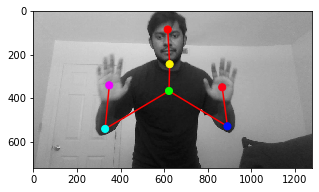

In [26]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create an augmentation pipeline
DeepPoseKit works with augmenters from the [imgaug package](https://github.com/aleju/imgaug).
This is a short example using spatial augmentations with axis flipping and affine transforms
See https://github.com/aleju/imgaug for more documentation on augmenters.

`deepposekit.augment.FlipAxis` takes the `DataGenerator` as an argument to get the keypoint swapping information defined in the annotation set. When the images are mirrored keypoints for left and right sides are swapped to avoid "confusing" the model during training.

In [28]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


Load an image-keypoints pair, apply augmentation, visualize it. Rerun this cell to see multiple random augmentations.

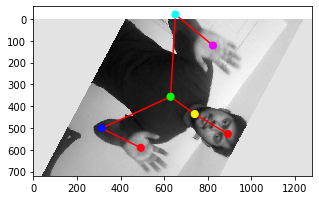

In [32]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create a `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [33]:
TrainingGenerator?

Init signature:
TrainingGenerator(
    generator,
    downsample_factor=2,
    use_graph=True,
    augmenter=None,
    shuffle=True,
    sigma=5,
    validation_split=0.0,
    graph_scale=1.0,
    random_seed=None,
)
Docstring:     
Generates data for training a model.

Automatically loads annotated data and produces
augmented images and confidence maps for each keypoint.

Parameters
----------
generator: deepposekit.io.BaseGenerator
    An instance of BaseGenerator (deepposekit.io.BaseGenerator) object.
    The output of the generator must be `(images, keypoints)`, where images
    are a numpy array of shape (n_images, height, width, channels), and 
    keypoints are a numpy array of shape (n_images, n_keypoints, 2), where
    2 is the row, column coordinates of the keypoints in each image.
downsample_factor : int, default = 0
    The factor for determining the output shape of the confidence
    maps for estimating keypoints. This is determined as
    shape // 2**downsample_factor. Th

In [34]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=3,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

C:\Users\Advait\Anaconda3\lib\site-packages\deepposekit\io\TrainingGenerator.py:176: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


{'n_train': 5,
 'n_validation': 0,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (90, 160),
 'n_output_channels': 16,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'E:\\Work\\github repos\\deepposekit_data_custom\\human\\example_annotation_set.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 5,
 'image_shape': (720, 1280, 1),
 'keypoints_shape': (7, 2)}

# Check the `TrainingGenerator` output
This plots the training data output from the `TrainingGenerator` to ensure that the augmentation is working and the confidence maps look good. Rerun this cell to see random augmentations. 

C:\Users\Advait\Anaconda3\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Method `Sequential.reseed()` is deprecated. Use `imgaug.augmenters.meta.Augmenter.seed_` instead.
  warn_deprecated(msg, stacklevel=3)


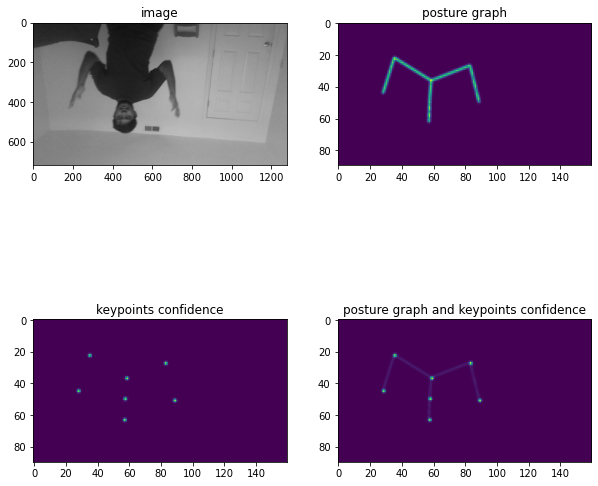

In [35]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Define a model
Here you can define a model to train with your data. You can use our `StackedDenseNet` model, `StackedHourglass` model, `DeepLabCut` model, or the `LEAP` model. The default settings for each model should work well for most datasets, but you can customize the model architecture. The `DeepLabCut` model has multiple pretrained (on ImageNet) backbones available for using transfer learning, including the original ResNet50 (He et al. 2015)  as well as the faster MobileNetV2 (Sandler et al. 2018; see  also Mathis et al. 2019) and DenseNet121 (Huang et al. 2017). We'll select `StackedDenseNet` and set `n_stacks=2` for 2 hourglasses, with `growth_rate=32` (32 filters per convolution). Adjust the `growth_rate` and/or `n_stacks` to change model performance (and speed). You can also set `pretrained=True` to use transfer learning with `StackedDenseNet`, which uses a DenseNet121 pretrained on ImageNet to encode the images.

In [36]:
from deepposekit.models import DeepLabCut, StackedDenseNet, StackedHourglass, LEAP

You can also look at the doc strings for any of the models to get more information:

In [38]:
StackedDenseNet?

Init signature:
StackedDenseNet(
    train_generator,
    n_stacks=1,
    n_transitions=-1,
    growth_rate=48,
    bottleneck_factor=1,
    compression_factor=0.5,
    pretrained=False,
    subpixel=True,
    **kwargs,
)
Docstring:      <no docstring>
Init docstring:
Define a Stacked DenseNet model from Graving et al. [1]
for pose estimation.
This model combines elements from [2-5]
See `References` for details on the model architecture.

Parameters
----------
train_generator : class deepposekit.io.TrainingGenerator
    A deepposekit.io.TrainingGenerator class for generating
    images and confidence maps.
n_stacks : int, default = 1
    The number of encoder-decoder networks to stack
    with intermediate supervision between stacks
n_transitions : int, default = -1
    The number of transition layers (downsampling and upsampling)
    in each encoder-decoder stack. If value is <0
    the number of transitions will be automatically set
    based on image size as the maximum number of po

In [39]:
DeepLabCut?

Init signature:
DeepLabCut(
    train_generator,
    subpixel=True,
    weights='imagenet',
    backbone='resnet50',
    alpha=1.0,
    **kwargs,
)
Docstring:     
Define a DeepLabCut model from Mathis et al., 2018 [1–4]
including MobileNetV2 backend from [4].
See `References` for details on the model architecture.

Parameters
----------
train_generator : class deepposekit.io.TrainingGenerator
    A deepposekit.io.TrainingGenerator class for generating
    images and confidence maps.
subpixel: bool, default = True
    Whether to use subpixel maxima for calculating
    keypoint coordinates in the prediction model.
weights: "imagnet" or None, default is "imagenet"
    Which weights to use for initialization. "imagenet" uses
    weights pretrained on imagenet. None uses randomly initialized
    weights.
backbone: string, default is "resnet50"
    pretrained backbone network to use. Must be one of ['resnet50', 'resnet101', 'resnet152', 'mobilenetv2', 'densenet121', 'densenet169', 'densenet

In [40]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)

#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
#model = StackedHourglass(train_generator)

model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 4,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 5,
 'n_validation': 0,
 'validation_split': 0.1,
 'downsample_factor': 3,
 'output_shape': (90, 160),
 'n_output_channels': 16,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 0.625,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'datapath': 'E:\\Work\\github repos\\deepposekit_data_custom\\human\\example_annotation_set.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 5,
 'image_shape': (720, 1280, 1),
 'keypoints_shape': (7, 2)}

# Test the prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [42]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:100], batch_size=20) # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=100, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

ResourceExhaustedError:  OOM when allocating tensor with shape[100,64,360,640] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node StackedDenseNet/densenet121/conv1/conv/Conv2D (defined at C:\Users\Advait\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_24889]

Function call stack:
keras_scratch_graph


# Define callbacks to enhance model training
Here you can define callbacks to pass to the model for use during training. You can use any callbacks available in `deepposekit.callbacks` or `tensorflow.keras.callbacks`

Remember, if you set `validation_split=0` for your `TrainingGenerator`, which will just use the training set for model fitting, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.


`Logger` evaluates the validation set (or training set if `validation_split=0` in the `TrainingGenerator`) at the end of each epoch and saves the evaluation data to a HDF5 log file (if `filepath` is set).

In [ ]:
logger = Logger(validation_batch_size=10,
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

`ReduceLROnPlateau` automatically reduces the learning rate of the optimizer when the validation loss stops improving. This helps the model to reach a better optimum at the end of training.

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

`ModelCheckpoint` automatically saves the model when the validation loss improves at the end of each epoch. This allows you to automatically save the best performing model during training, without having to evaluate the performance manually.


In [ ]:
model_checkpoint = ModelCheckpoint(
    HOME + video_file_path + "best_model_densenet.h5",
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
)

`EarlyStopping` automatically stops the training session when the validation loss stops improving for a set number of epochs, which is set with the `patience` argument. This allows you to save time when training your model if there's not more improvment.

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)

Create a list of callbacks to pass to the model

In [ ]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

# Fit the model

This fits the model for a set number of epochs with small batches of data. If you have a small dataset initially you can set `batch_size` to a small value and manually set `steps_per_epoch` to some large value, e.g. 500, to increase the number of batches per epoch, otherwise this is automatically determined by the size of the dataset.

The number of `epochs` is set to `epochs=200` for demonstration purposes. **Increase the number of epochs to train the model longer, for example `epochs=1000`**. The `EarlyStopping` callback will then automatically end training if there is no improvement. See the doc string for details:

In [ ]:
model.fit?

In [ ]:
model.fit(
    batch_size=16,
    validation_batch_size=10,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=5,
    n_workers=8,
    steps_per_epoch=None,
)

# Load the model and resume training

This loads the saved model and passes it the augmentation pipeline and `DataGenerator` from earlier.

In [ ]:
model = load_model(
    HOME + video_file_path + "best_model_densenet.h5",
    augmenter=augmenter,
    generator=data_generator,
)

To resume training, simply call `model.fit` again. We'll run it for another 30 `epochs`

In [ ]:
model.fit(
    batch_size=16,
    validation_batch_size=10,
    callbacks=callbacks,
    epochs=2,
    n_workers=8,
    steps_per_epoch=None,
)